In [29]:
import scanpy as sc
import numpy as np
import phate
import scprep
import seaborn as sns
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
adata = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [4]:
# convert clusters to more coarse cell types to use PanglaoDB markers for downstream analysis
conv = dict(zip(adata.obs['louvain'].cat.categories,
['T cells', 'Monocytes', 'B cells', 'T cells', 'NK cells', 'Monocytes', 'Dendritic cells', 'Megakaryocytes']))
adata.obs['cell_types'] = [conv[x] for x in adata.obs['louvain']]

## Re-embed with localized genes

In [7]:
results = np.load('../results/pbmc_gene_embedding.npz', allow_pickle=True)

In [11]:
threshold = np.percentile(results['localization_score'], q=75)
localized_genes = results['genes'][results['localization_score'] > threshold]
loc_phate_op = phate.PHATE(random_state=42, verbose=False)
data_loc_phate = loc_phate_op.fit_transform(adata[:, localized_genes].to_df())

<Axes: title={'center': 'Embedding top loc genes'}>

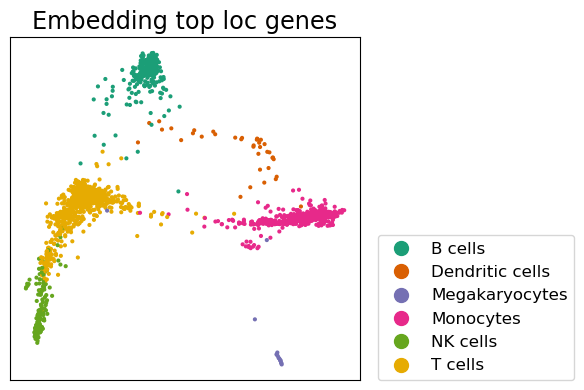

In [16]:
scprep.plot.scatter2d(data_loc_phate, c=adata.obs['cell_types'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding top loc genes', filename='figures/pbmc_loc_reembedding.png', cmap='Dark2')

In [17]:
threshold = np.percentile(results['localization_score'], q=25)
nonlocalized_genes = results['genes'][results['localization_score'] < threshold]
nonloc_phate_op = phate.PHATE(random_state=42, verbose=False)
data_nonloc_phate = nonloc_phate_op.fit_transform(adata[:, nonlocalized_genes].to_df())

<Axes: title={'center': 'Embedding bottom loc genes'}>

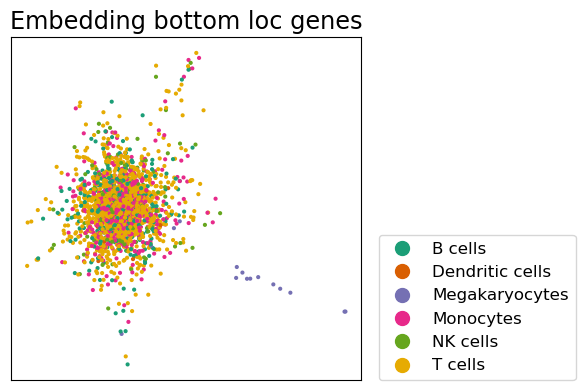

In [18]:
scprep.plot.scatter2d(data_nonloc_phate, c=adata.obs['cell_types'], legend_loc=(1.05, 0), figsize=(6,4), ticks=None, dpi=300,
                      title='Embedding bottom loc genes', filename='figures/pbmc_nonloc_reembedding.png', cmap='Dark2')

## Correlation between geodesic distances

In [20]:
phate_op = phate.PHATE(random_state=42, verbose=False)
data_phate = phate_op.fit_transform(adata.to_df())

In [23]:
true_geodesic_dist = phate_op.graph.shortest_path(distance='affinity')
true_geodesic_dist = squareform(true_geodesic_dist, checks=False) # is symmetric within tolerance

In [24]:
corrs= []
for _ in range(2):
    idx = np.random.choice(true_geodesic_dist.shape[0], size=100000, replace=False)
    for j,p in enumerate([loc_phate_op, nonloc_phate_op]):
        geodesic_dist = p.graph.shortest_path(distance='affinity')
        geodesic_dist = squareform(geodesic_dist, checks=False) # is symmetric within tolerance
        corr = spearmanr(true_geodesic_dist[idx], geodesic_dist[idx])
        corrs.append(corr)
        print (j, corr)

0 SignificanceResult(statistic=0.6848327448848222, pvalue=0.0)
1 SignificanceResult(statistic=0.13492279176999053, pvalue=0.0)
0 SignificanceResult(statistic=0.6848529970869346, pvalue=0.0)
1 SignificanceResult(statistic=0.13621067121137165, pvalue=0.0)


In [27]:
df = pd.DataFrame([['Localized', 'Non-localized', 'Localized', 'Non-localized'], 
             [c.statistic for c in corrs]]).T

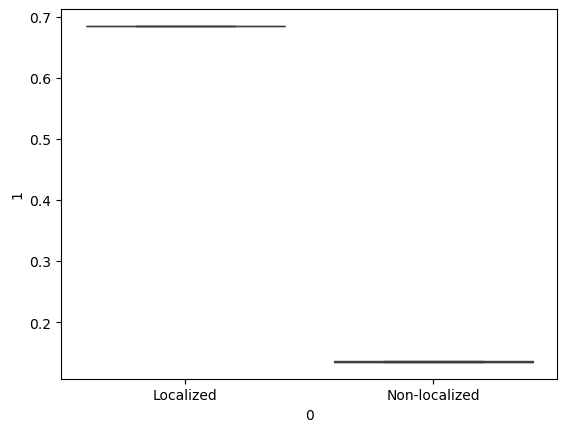

In [30]:
fig, ax = plt.subplots()
sns.boxplot(data=df, x=0, y=1, ax=ax)
fig.savefig('figures/pbmc_geodesic_spearmanr.png', dpi=200)

In [315]:
phate_op = phate.PHATE(random_state=42, verbose=False, t=40)
data_phate = phate_op.fit_transform(results['signal_embedding'])

In [316]:
all_markers = pd.read_csv('data/PanglaoDB_markers.tsv', sep='\t')
cell_types = ['T cells', 'Monocytes', 'B cells', 'NK cells', 'Dendritic cells', 'Megakaryocytes']
all_markers = all_markers[(all_markers['cell type'].isin(cell_types)) & (all_markers['canonical marker'] == 1.0)]

In [317]:
gene_embedding_markers = {}

In [318]:
for cell_type in cell_types:
    cell_type_genes = all_markers[all_markers['cell type'] == cell_type]['official gene symbol'].tolist()
    gene_embedding_markers[cell_type] = set(cell_type_genes).intersection(results['genes'])

In [320]:
gene_embedding_markers_loc = {}

In [321]:
for cell_type in cell_types:
    x = adata.to_df()[list(gene_embedding_markers[cell_type])].groupby(adata.obs['cell_types']).mean()
    gene_embedding_markers_loc[cell_type] = x.idxmax()[x.idxmax() == cell_type].index.tolist()

In [322]:
vis_markers = []
vis_marker_cell_type = []
for k,v in gene_embedding_markers_loc.items():
    vis_marker_cell_type.extend([k[:-1] + ' gene markers']*len(v))
    vis_markers.extend(v)
vis_markers = pd.DataFrame([vis_markers, vis_marker_cell_type]).T.set_index(0)
vis_markers = vis_markers.loc[results['genes'][pd.Series(results['genes']).isin(vis_markers.index)]]

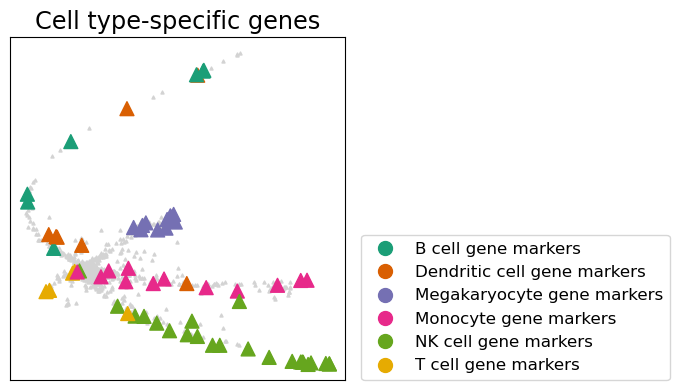

In [392]:
fig, ax = plt.subplots(figsize=(7,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
scprep.plot.scatter2d(data_phate[pd.Series(results['genes']).isin(vis_markers.index)], cmap='Dark2',
                      marker='^', c=vis_markers[1], ax=ax, s=100, legend_loc=(1.05,0), dpi=300,
                      title='Cell type-specific genes')
plt.tight_layout()
fig.savefig('results/pbmc_results/cell_type_specific_genes.png', dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


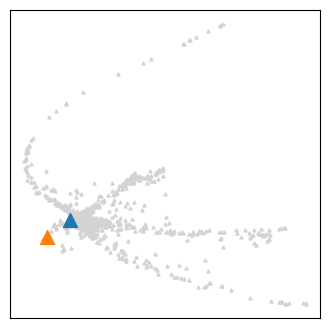

In [361]:
my_markers = ['ICOS', 'CD2']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


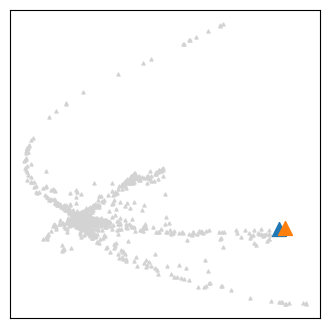

In [355]:
my_markers = ['MS4A6A', 'S100A8']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/pyt

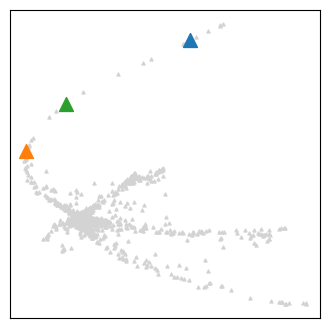

In [372]:
my_markers = ['MS4A1', 'CD19', 'CD72']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/pyt

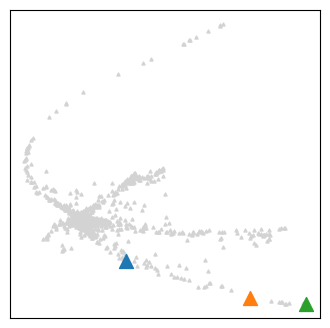

In [383]:
my_markers = ['KLRG1', 'GNLY', 'NKG7']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


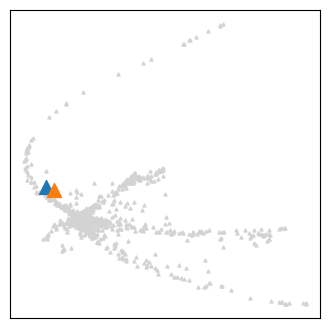

In [382]:
my_markers = ['CD1C', 'FCER1A']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/scprep/plot/scatter.py:753: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


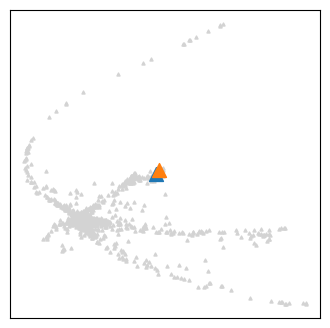

In [385]:
my_markers = ['ITGA2B', 'GP9']
fig, ax = plt.subplots(figsize=(4,4))
scprep.plot.scatter2d(data_phate, marker='^', c='lightgray', ax=ax, ticks=None)
for i,marker in enumerate(my_markers):
    scprep.plot.scatter2d(data_phate, mask=results['genes'] == marker,
                      marker='^', c=plt.get_cmap('tab10')(i), ax=ax, s=100, legend_loc=(1.05,0), dpi=300)